# **CNN and ResNet Assignments**

Apply the CNN and ResNet models on the cifar-10 dataset to classify images. You can start with the code at Kera's site BUT observe the effects on accuracy by adding/reducing extra convolution, dropout, and batch normalization layers. Prepare about six slides to present your findings.

### **Applying CNN Model on cifar-10 dataset**

In [1]:
! pip install keras
! pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# https://keras.io/examples/cifar10_cnn/

from __future__ import print_function
import tensorflow as tf
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import os
from math import ceil

batch_size = 32
num_classes = 10
epochs = 6
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

In [3]:
# The data, split between train and test datasets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(y_test)
print('\nX_Train shape:', x_train.shape,'\n')
print(x_train.shape[0], 'Training samples')
print(x_test.shape[0], 'Testing samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170498071/170498071 [==============================] - 2s 0us/step
[[3]
 [8]
 [8]
 ...
 [5]
 [1]
 [7]]

X_Train shape: (50000, 32, 32, 3) 

50000 Training samples
10000 Testing samples


In [4]:
# Original Model 1
n_points = len(x_train)
steps_per_epoch = ceil(n_points / batch_size)

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [5]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        steps_per_epoch=steps_per_epoch, # SUBRATA added
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Using real-time data augmentation.
Epoch 1/6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


1563/1563 [==============================] - 176s 112ms/step - loss: 1.8432 - accuracy: 0.3188 - val_loss: 1.5251 - val_accuracy: 0.4411
Epoch 2/6
1563/1563 [==============================] - 167s 107ms/step - loss: 1.5724 - accuracy: 0.4262 - val_loss: 1.3720 - val_accuracy: 0.5044
Epoch 3/6
1563/1563 [==============================] - 168s 107ms/step - loss: 1.4595 - accuracy: 0.4716 - val_loss: 1.3047 - val_accuracy: 0.5294
Epoch 4/6
1563/1563 [==============================] - 180s 115ms/step - loss: 1.3753 - accuracy: 0.5056 - val_loss: 1.2499 - val_accuracy: 0.5534
Epoch 5/6
1563/1563 [==============================] - 179s 115ms/step - loss: 1.3112 - accuracy: 0.5310 - val_loss: 1.1814 - val_accuracy: 0.5739
Epoch 6/6
1563/1563 [==============================] - 177s 113ms/step - loss: 1.2505 - accuracy: 0.5554 - val_loss: 1.0852 - val_accuracy: 0.6128
Saved trained model at /content/saved_models/keras_cifar10_trained_model.h5 


In [6]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
model1acc = scores[1]
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 8s 26ms/step - loss: 1.0852 - accuracy: 0.6128
Test loss: 1.085150122642517
Test accuracy: 0.6128000020980835


In [7]:
model_path = os.path.join(save_dir, model_name)
model2 = load_model(model_path)
#model.compile(optimizer=opt, loss='categorical_crossentropy')
y_predict = model2.predict(x_test)

313/313 [==============================] - 8s 26ms/step


(10000, 32, 32, 3) (10000, 10)
[0.00435877 0.00120485 0.0426312  0.43741065 0.01294268 0.4152494
 0.07150008 0.00832442 0.00467198 0.001706  ]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


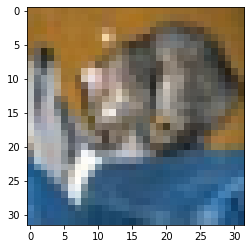

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print(x_test.shape, y_test.shape)
#img=mpimg.imread(x_test[0])
#imgplot = plt.imshow(img)
#plt.show()
plt.imshow(x_test[0])
print(y_predict[0])
print(y_test[0])

In [9]:
# Model 2
n_points = len(x_train)
steps_per_epoch = ceil(n_points / batch_size)

model2 = Sequential()
model2.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Dense(128))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(Dropout(0.25))

model2.add(Conv2D(256, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(256, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_6 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 15, 15, 32)        0         
                                                      

In [10]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model2.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        steps_per_epoch=steps_per_epoch, # SUBRATA added
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path2 = os.path.join(save_dir, model_name)
model2.save(model_path2)
print('Saved trained model at %s ' % model_path2)

Using real-time data augmentation.
Epoch 1/6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


1563/1563 [==============================] - 329s 210ms/step - loss: 2.0782 - accuracy: 0.2030 - val_loss: 2.1053 - val_accuracy: 0.2302
Epoch 2/6
1563/1563 [==============================] - 389s 249ms/step - loss: 1.8443 - accuracy: 0.3090 - val_loss: 4.8401 - val_accuracy: 0.1854
Epoch 3/6
1563/1563 [==============================] - 355s 227ms/step - loss: 1.7115 - accuracy: 0.3684 - val_loss: 1.6581 - val_accuracy: 0.3917
Epoch 4/6
1563/1563 [==============================] - 325s 208ms/step - loss: 1.6172 - accuracy: 0.4105 - val_loss: 1.9673 - val_accuracy: 0.3421
Epoch 5/6
1563/1563 [==============================] - 324s 207ms/step - loss: 1.5551 - accuracy: 0.4363 - val_loss: 2.0140 - val_accuracy: 0.3263
Epoch 6/6
1563/1563 [==============================] - 325s 208ms/step - loss: 1.4884 - accuracy: 0.4621 - val_loss: 2.5532 - val_accuracy: 0.3187
Saved trained model at /content/saved_models/keras_cifar10_trained_model.h5 


In [11]:
# Score trained model.
scores2 = model2.evaluate(x_test, y_test, verbose=1)
model2acc = scores2[1]
print('Test loss:', scores2[0])
print('Test accuracy:', scores2[1])

313/313 [==============================] - 13s 40ms/step - loss: 2.5532 - accuracy: 0.3187
Test loss: 2.5532214641571045
Test accuracy: 0.31869998574256897


In [12]:
model_path2 = os.path.join(save_dir, model_name)
model22 = load_model(model_path2)
#model.compile(optimizer=opt, loss='categorical_crossentropy')
y_predict2 = model22.predict(x_test)

313/313 [==============================] - 13s 42ms/step


(10000, 32, 32, 3) (10000, 10)
[1.64441706e-04 5.88374423e-05 1.31098777e-01 3.68854403e-02
 9.12984759e-02 6.80154609e-03 7.32149601e-01 1.35538646e-03
 7.22647310e-05 1.15245915e-04]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


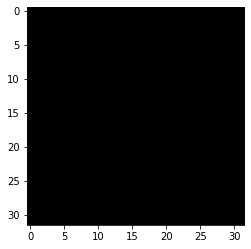

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print(x_test.shape, y_test.shape)
#img=mpimg.imread(x_test[0])
#imgplot = plt.imshow(img)
#plt.show()
plt.imshow(x_test[0])
print(y_predict2[0])
print(y_test[0])

In [38]:
# Accuracy Comparison of Models
print("--------------------------------------------")
print("Testing Accuarcy of Original Model without any addition")
print("Testing Accuracy:",(model1acc)*100,"%")
print("")
print("--------------------------------------------")
print("Testing Accuarcy of Model with extra layer of Batch Normalization and Convolution Layer")
print("Testing Accuracy:",(model2acc)*100,"%")

--------------------------------------------
Testing Accuarcy of Original Model without any addition
Testing Accuracy: 61.28000020980835 %

--------------------------------------------
Testing Accuarcy of Model with extra layer of Batch Normalization and Convolution Layer
Testing Accuracy: 31.869998574256897 %


### **Applying ResNet Model on cifar-10 dataset**

In [17]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
from math import ceil

In [18]:
# Training parameters
batch_size = 32
epochs = 4
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# SUBRATA added
n_points = len(x_train)
steps_per_epoch = ceil(n_points / batch_size)

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [19]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [20]:
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 32, 32, 16)  64          ['conv2d_10[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activation_15 (Activation)     (None, 32, 32, 16)   0           ['batch

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Trainable params: 273,066
Non-trainable params: 1,376
__________________________________________________________________________________________________
ResNet20v1


In [21]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        steps_per_epoch=steps_per_epoch,
                        callbacks=callbacks)

Using real-time data augmentation.
Learning rate:  0.001
Epoch 1/4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


1563/1563 [==============================] - ETA: 0s - loss: 1.5830 - accuracy: 0.4849

1563/1563 [==============================] - 430s 273ms/step - loss: 1.5830 - accuracy: 0.4849 - val_loss: 1.4443 - val_accuracy: 0.5525 - lr: 0.0010
Learning rate:  0.001
Epoch 2/4
1563/1563 [==============================] - ETA: 0s - loss: 1.1952 - accuracy: 0.6321

1563/1563 [==============================] - 425s 272ms/step - loss: 1.1952 - accuracy: 0.6321 - val_loss: 1.5014 - val_accuracy: 0.5492 - lr: 0.0010
Learning rate:  0.001
Epoch 3/4
1563/1563 [==============================] - ETA: 0s - loss: 1.0270 - accuracy: 0.6958

1563/1563 [==============================] - 425s 272ms/step - loss: 1.0270 - accuracy: 0.6958 - val_loss: 1.1340 - val_accuracy: 0.6665 - lr: 0.0010
Learning rate:  0.001
Epoch 4/4
1563/1563 [==============================] - ETA: 0s - loss: 0.9298 - accuracy: 0.7333

1563/1563 [==============================] - 427s 273ms/step - loss: 0.9298 - accuracy: 0.7333 - val_loss: 0.9814 - val_accuracy: 0.7185 - lr: 0.0010


In [22]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
resnetmodel1acc = scores[1]
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 29s 92ms/step - loss: 0.9814 - accuracy: 0.7185
Test loss: 0.9814386963844299
Test accuracy: 0.718500018119812


In [29]:
# Training parameters of original resnet model
batch_size = 32
epochs1 = 4
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n1 = 5

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version1 = 1

# Computed depth from supplied model parameter n
if version1 == 1:
    depth1 = n1 * 6 + 2
elif version1 == 2:
    depth1 = n1 * 9 + 2

# Model name, depth and version
model_type1 = 'ResNet%dv%d' % (depth1, version1)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

n_points = len(x_train)
steps_per_epoch = ceil(n_points / batch_size)

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('X_Train shape:', x_train.shape,'\n')
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('\nY_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

X_Train shape: (50000, 32, 32, 3) 

50000 train samples
10000 test samples

Y_train shape: (50000, 1)


In [30]:
if version1 == 2:
    model1 = resnet_v2(input_shape=input_shape, depth=depth1)
else:
    model1 = resnet_v1(input_shape=input_shape, depth=depth1)

model1.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model1.summary()
print(model_type1)

Learning rate:  0.001
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_176 (Conv2D)            (None, 32, 32, 16)   448         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_160 (Batch  (None, 32, 32, 16)  64          ['conv2d_176[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_174 (Activation)    (None, 32, 32, 16)   0           ['bat

In [31]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name1 = 'cifar10_%s_model.{epoch:03d}.h5' % model_type1
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name1)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model1.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs1,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model1.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs1, verbose=1, workers=4,
                        steps_per_epoch=steps_per_epoch,
                        callbacks=callbacks)

Using real-time data augmentation.
Learning rate:  0.001
Epoch 1/4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


1563/1563 [==============================] - ETA: 0s - loss: 1.6572 - accuracy: 0.4891

1563/1563 [==============================] - 741s 447ms/step - loss: 1.6572 - accuracy: 0.4891 - val_loss: 2.0613 - val_accuracy: 0.4513 - lr: 0.0010
Learning rate:  0.001
Epoch 2/4
1563/1563 [==============================] - ETA: 0s - loss: 1.2246 - accuracy: 0.6450

1563/1563 [==============================] - 721s 461ms/step - loss: 1.2246 - accuracy: 0.6450 - val_loss: 1.2315 - val_accuracy: 0.6576 - lr: 0.0010
Learning rate:  0.001
Epoch 3/4
1563/1563 [==============================] - ETA: 0s - loss: 1.0544 - accuracy: 0.7093

1563/1563 [==============================] - 718s 460ms/step - loss: 1.0544 - accuracy: 0.7093 - val_loss: 1.0069 - val_accuracy: 0.7289 - lr: 0.0010
Learning rate:  0.001
Epoch 4/4
1563/1563 [==============================] - ETA: 0s - loss: 0.9637 - accuracy: 0.7397

1563/1563 [==============================] - 725s 464ms/step - loss: 0.9637 - accuracy: 0.7397 - val_loss: 1.0657 - val_accuracy: 0.7098 - lr: 0.0010


In [32]:
# Score trained model.
scores2 = model1.evaluate(x_test, y_test, verbose=1)
resnetmodel2acc = scores2[1]
print('Test loss:', scores2[0])
print('Test accuracy:', scores2[1])

313/313 [==============================] - 31s 98ms/step - loss: 1.0657 - accuracy: 0.7098
Test loss: 1.0656744241714478
Test accuracy: 0.7098000049591064


In [39]:
# Accuracy Comparison of ResNet Models
print("--------------------------------------------")
print("Testing Accuarcy of Original ResNet Model ResNet20")
print("Testing Accuracy:",(resnetmodel1acc)*100,"%")
print("")
print("--------------------------------------------")
print("Testing Accuarcy of ResNet Model with different model type ResNet32")
print("Testing Accuracy:",(resnetmodel2acc)*100,"%")

--------------------------------------------
Testing Accuarcy of Original ResNet Model ResNet20
Testing Accuracy: 71.8500018119812 %

--------------------------------------------
Testing Accuarcy of ResNet Model with different model type ResNet32
Testing Accuracy: 70.98000049591064 %
